* Autoregressive model -> model that predicts X<sub>t</sub> using X<sub>t-1</sub>..X<sub>t-$\alpha$</sub>
* Latent Autoregressive model -> Keep summary h<sub>t</sub> of all observations

$$p(x_1, \ldots, x_T) = \prod_{t=1}^T p(x_t \mid x_{t-1})$$
Markov model of first order, $\alpha = 1 $
Predicting x<sub>t</sub> depends only on moment $t-1$, recursively.

Using some dynamic programming:
$$p(x_{t+1} \mid x_{t-1}) = \sum_{x_t} p(x_{t+1} \mid x_t) p(x_t \mid x_{t-1}).$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch.utils import data

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

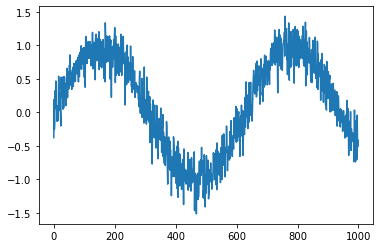

In [2]:
T = 1000
time = np.arange(0, T)
x = np.sin(0.01 * time) + 0.2 * np.random.normal(size=T)
x = torch.from_numpy(x).type(torch.FloatTensor)
plt.plot(time, x)

In [3]:
tau = 8
features = torch.zeros((T-tau, tau))
for i in range(tau):
    features[:, i] = x[i: T-tau+i]
labels = x[tau:]

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0699, 0.0799,
        0.0899])
tensor([0.0000, 0.0100, 0.0200, 0.0300])
tensor(0.0400)


In [4]:
batch_size, n_train = 16, 600
train_iter = data.TensorDataset(features[:n_train], labels[:n_train])
train_loader = data.DataLoader(train_iter, batch_size=batch_size)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(tau, 12)
        self.fc2 = nn.Linear(12, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [6]:
net = Net()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

In [7]:
best = [float('inf'), None]

for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0], data[1]

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs).view(-1,)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        if loss.item() < best[0]:
            best[1] = net.state_dict()
            best[0] = running_loss

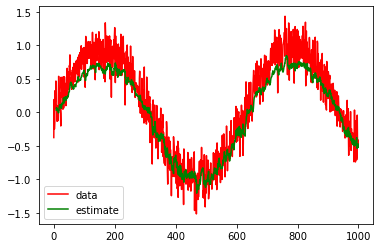

In [8]:
estimates = net(features)
plt.plot(time, x, 'r', label='data')
plt.plot(time[tau:], estimates.detach().numpy(), 'g', label='estimate')
plt.legend()

In [9]:
predictions = torch.zeros(T)
predictions[:n_train] = x[:n_train]
for i in range(n_train, T):
    predictions[i] = net(predictions[(i-tau):i]).view(-1,)

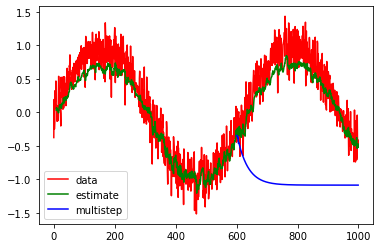

In [10]:
plt.plot(time, x, 'r', label='data')
plt.plot(time[tau:], estimates.detach().numpy(), 'g', label='estimate')
plt.plot(time[n_train:], predictions[n_train:].detach().numpy(), 'b', label='multistep')
plt.legend()

First prediction comes with $\epsilon_1 = \bar\epsilon$ error rate. By definition of autoregressive models, we use our prediction $\x_n$ in order to predict $x_{n+1}$, leading to a compund error $\epsilon_2 = \bar\epsilon + L_{\epsilon_1}$.